In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

import nltk
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score



In [2]:
# Upload data on google drive and call it in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# copy data file into content in colab to be used 
!cp /content/drive/My\ Drive/State_of_Art_Models/Reviews.csv.zip /content 


In [6]:
# convert zip files to normal file so we can call its content 
!unzip /content/Reviews.csv.zip


Archive:  /content/Reviews.csv.zip
  inflating: Reviews.csv             


In [7]:
df = pd.read_csv('/content/Reviews.csv')

In [8]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [9]:
df.shape

(568454, 10)

In [10]:
df = df.sample(frac= 0.20,replace = True).reset_index(drop = True)

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,168365,B000LDOT58,A2PIZ0LHH5VL36,"Carolyne A. Humphrey ""C. Humphrey""",0,0,4,1231200000,high interest,This product makes a chew treat last longer wh...
1,428357,B0029JS3XG,A3MWL4FO0J9O29,Joe44060,2,3,5,1248307200,Pillsbury cranberry bread is my favorite,I have been making Pillsbury bread mixes for a...
2,336817,B004IFKSLY,A53NMNQVDLCXC,"Leann ""talltori""",0,0,4,1350950400,BRAND NEW CAT!!!!!!,My cat is the most nervous cat I've ever met. ...
3,474939,B00347AL5U,A3USGDUZJ8YGEN,Jamie L. Landuyt,2,2,5,1336003200,Just as described,I received my purchase quickly and well packag...
4,137057,B004XNZLMM,A2VNP7RVCIQH19,S Falcon - Seattle,0,0,3,1330041600,Dog Treats,These Chicken and Sweet Potato dog treats are ...


In [11]:
df.shape

(113691, 10)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113691 entries, 0 to 113690
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      113691 non-null  int64 
 1   ProductId               113691 non-null  object
 2   UserId                  113691 non-null  object
 3   ProfileName             113688 non-null  object
 4   HelpfulnessNumerator    113691 non-null  int64 
 5   HelpfulnessDenominator  113691 non-null  int64 
 6   Score                   113691 non-null  int64 
 7   Time                    113691 non-null  int64 
 8   Summary                 113689 non-null  object
 9   Text                    113691 non-null  object
dtypes: int64(5), object(5)
memory usage: 8.7+ MB


In [13]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [14]:
df.dropna(inplace= True)

In [15]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

What is the distribution of ratings across dataset

In [16]:
rating_pct = df['Score'].value_counts()/len(df) * 100
rating_pct

5    64.008761
4    14.138944
1     9.163837
3     7.583168
2     5.105290
Name: Score, dtype: float64

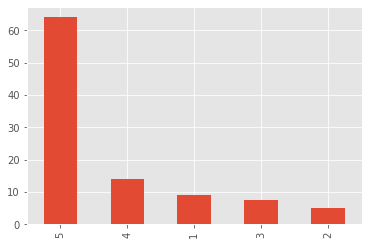

In [17]:
rating_pct.plot.bar()
plt.show()

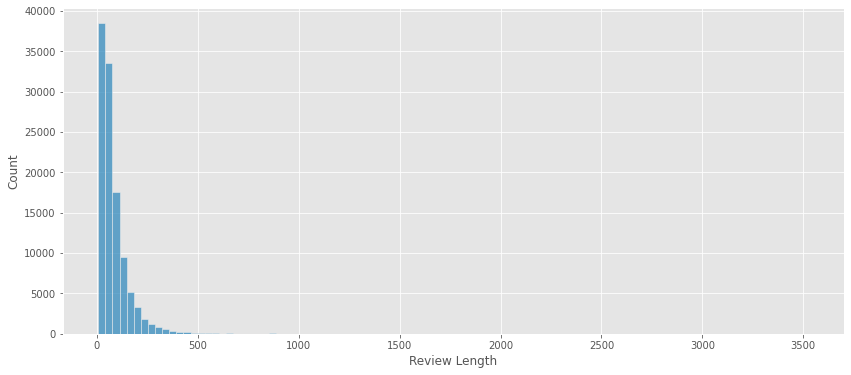

In [18]:
#words per review
plt.figure(figsize = (14,6))
WordsPerReview = df['Text'].apply(lambda x: len(x.split(' ')))

sns.histplot(WordsPerReview,bins = 100)

plt.xlabel('Review Length')
plt.show()

#### Word cloud

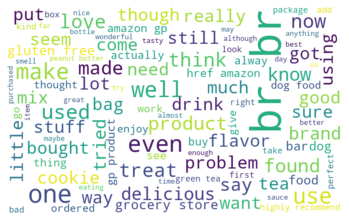

In [19]:
txt = ' '.join(review for review in df.Text)

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Data Preprocessing and Transformation

In [20]:
df = pd.DataFrame(df,columns = ['Score','Text'])
df.rename(columns = {'Score':'Rating','Text':'Review'},inplace = True)

In [21]:
def apply_sentiment(Rating):
    if(Rating <=2 ):
        return 0
    else:
        return 1

In [22]:
df['Sentiment'] = df['Rating'].apply(apply_sentiment)
df.drop(['Rating'],axis = 1, inplace = True)

In [23]:
sentiment = df['Sentiment'].value_counts()
sentiment

1    97464
0    16222
Name: Sentiment, dtype: int64

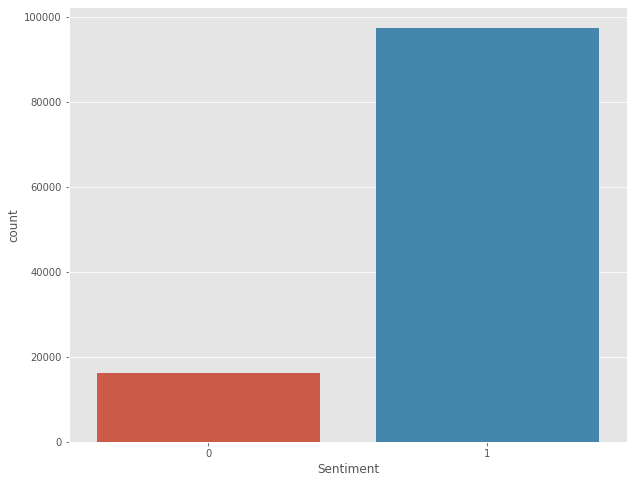

In [24]:
plt.figure(figsize = ( 10,8))
sns.countplot(data = df, x = 'Sentiment')
plt.show()

In [64]:
def clean_text(Review):
   
    Review = str(Review).lower() # convert to lowercase
    Review = re.sub('\[.*?\]', '', Review) 
    Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
    Review = re.sub('<.*?>+', '', Review)
    Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
    Review = re.sub('\n', '', Review)
    Review = re.sub('\w*\d\w*', '', Review)
    return Review


In [65]:
df['Review'] = df['Review'].apply(clean_text)

In [66]:
df.head()

,Review,Sentiment,reviews_text
0,this product makes a chew treat last longer wh...,1,"[product, makes, chew, treat, last, longer, us..."
1,i have been making pillsbury bread mixes for a...,1,"[making, pillsbury, bread, mixes, least, five,..."
2,my cat is the most nervous cat ive ever met pr...,1,"[cat, nervous, cat, ive, ever, met, probably, ..."
3,i received my purchase quickly and well packag...,1,"[received, purchase, quickly, well, packaged, ..."
4,these chicken and sweet potato dog treats are ...,1,"[chicken, sweet, potato, dog, treats, time, fa..."


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113686 entries, 0 to 113690
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Review        113686 non-null  object
 1   Sentiment     113686 non-null  int64 
 2   reviews_text  113686 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.5+ MB


In [55]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [57]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stopword = []
sentence = df['Review'][0]


words = nltk.word_tokenize(sentence)


def remove_stopword(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

df['reviews_text'] = df['Review'].apply(lambda row: remove_stopword(stop_words, row))

In [68]:
df.head(3)

,Review,Sentiment,reviews_text
0,this product makes a chew treat last longer wh...,1,"[product, makes, chew, treat, last, longer, us..."
1,i have been making pillsbury bread mixes for a...,1,"[making, pillsbury, bread, mixes, least, five,..."
2,my cat is the most nervous cat ive ever met pr...,1,"[cat, nervous, cat, ive, ever, met, probably, ..."


In [69]:
X = df['Review']
y = df['Sentiment']


In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape,y_train.shape

((90948,), (22738,), (90948,))

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
clf = Pipeline([
    ('vect',CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

In [72]:
fit_model = clf.fit(X_train,y_train)

In [73]:
y_pred = clf.predict(X_test)

In [74]:
print('Training accuracy:', fit_model.score(X_train,y_train))
print('Test accuracy:', fit_model.score(X_test,y_test))

Training accuracy: 0.8588534107402032
Test accuracy: 0.8615973260620987


In [75]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))

print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02      3173
           1       0.86      1.00      0.93     19565

    accuracy                           0.86     22738
   macro avg       0.93      0.50      0.47     22738
weighted avg       0.88      0.86      0.80     22738

[[   26  3147]
 [    0 19565]]


# Test Model on Our Dataset

In [76]:
!cp /content/drive/MyDrive/Sentiment_Analysis/data.zip /content 

In [77]:
# convert zip files to normal file so we can call its content 
!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [78]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [79]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

In [80]:
def preprocess(textdata):
    processedText = []

    # Defining dictionary containing all emojis with their meanings.
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
    stopwords_english = stopwords.words('english')
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if (word not in stopwords_english):
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)

        
    return processedText

In [81]:
# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [83]:
from nltk.stem import WordNetLemmatizer

In [85]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [86]:
processed_text = preprocess(text)

In [89]:
train_X, test_X, train_y, test_y = train_test_split(processed_text, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [90]:
prediction = clf.predict(test_X)

In [92]:
print('Test accuracy:', fit_model.score(test_X,test_y))

Test accuracy: 0.50099375


In [96]:
print(classification_report(test_y,prediction))
print(confusion_matrix(test_y,prediction))

              precision    recall  f1-score   support

           0       0.85      0.00      0.00    159815
           1       0.50      1.00      0.67    160185

    accuracy                           0.50    320000
   macro avg       0.68      0.50      0.33    320000
weighted avg       0.68      0.50      0.34    320000

[[   161 159654]
 [    28 160157]]


# Test Our Model on Data-Set

In [97]:
from tensorflow.keras.models import load_model

In [99]:
model = load_model('/content/Sentiment_Analysis_LSTM.hdf5',compile = False)

In [101]:
def preprocess(textdata):
    processedText = []

    # Defining dictionary containing all emojis with their meanings.
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
    stopwords_english = stopwords.words('english')
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if (word not in stopwords_english):
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)

        
    return processedText

In [106]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [107]:
def extract_feature(process_text):
      df = pd.DataFrame (process_text, columns = ['text'])
      max_fatures = 5000
      tokenizer = Tokenizer(num_words=max_fatures, split=' ')
      tokenizer.fit_on_texts(df['text'].values)
      to_seq = tokenizer.texts_to_sequences(df['text'].values)
      pad_seq = pad_sequences(to_seq) # to make words at the same length 
      return pad_seq

In [108]:
def prdeiction_fun(sample_input):
    df = pd.DataFrame (sample_input, columns = ['text'])
    processed_text = preprocess(df)
    extracted_text = extract_feature( processed_text)
    prediction_text = model.predict(extracted_text)
    print(prediction_text)

In [109]:
prdeiction_fun(X)   #first argument is loss & second argument is accuarcy 

[[0.33976623 0.66023374]]
